# Config

In [13]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Global variables
REPO_DIR: Path = Path("..").resolve()
assert REPO_DIR.name == "market-regime-classification", "`REPO_DIR` points to incorrect folder."
DATA_PATH: Path = REPO_DIR / "data/preprocessed"

# Data

### data import

In [2]:
# Data import (with labels)
df = pd.read_csv(DATA_PATH / "daily_prices_with_labels.csv").set_index("trading_date").sort_index()

### data scaling

<Axes: xlabel='trading_date'>

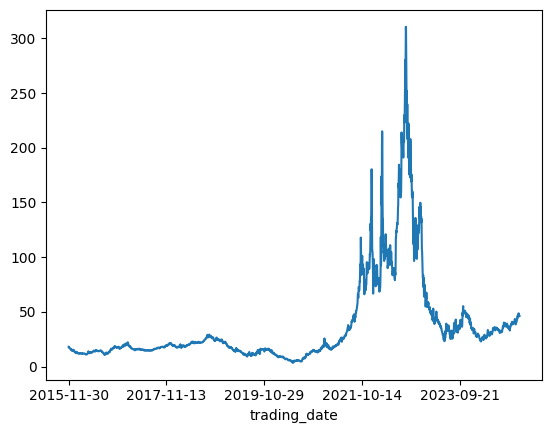

In [3]:
df["close"].plot()

<Axes: xlabel='trading_date'>

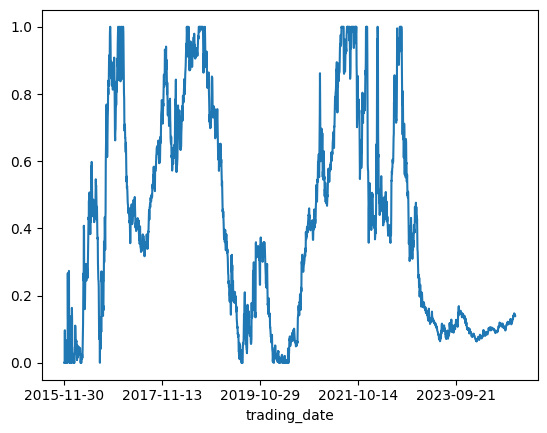

In [4]:
# using min max
(
    (df["close"] - df["close"].expanding().min())
    / (df["close"].expanding().max() - df["close"].expanding().min())
).plot()

<Axes: xlabel='trading_date'>

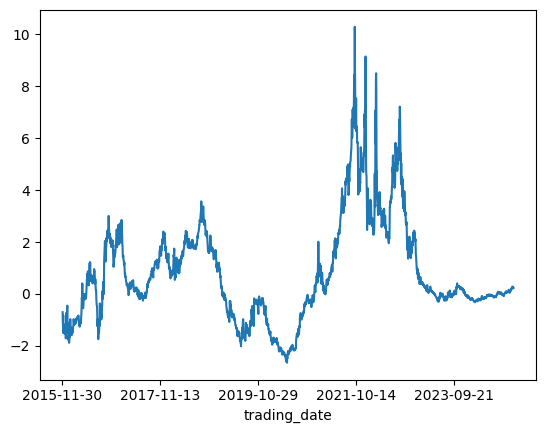

In [5]:
# using z-score
((df["close"] - df["close"].expanding().mean()) / df["close"].expanding().std()).plot()

<Axes: xlabel='trading_date'>

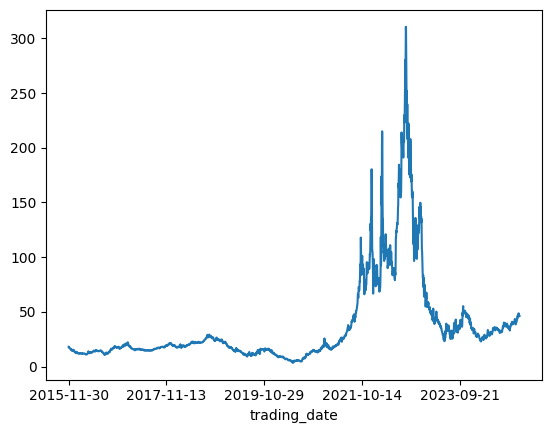

In [6]:
df["close"].plot()

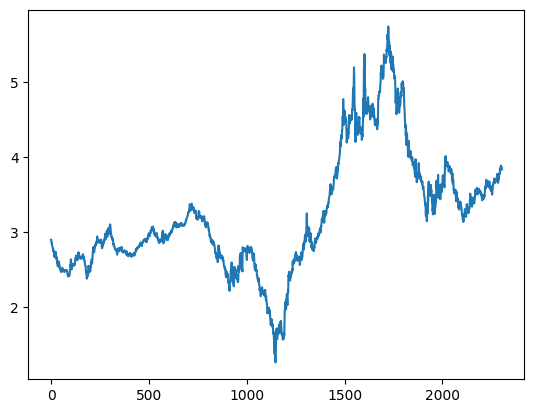

In [7]:
plt.plot(np.log(df["close"].to_numpy()))

In [8]:
def transform_price(x: np.ndarray, window: int = 60, log: bool = True, scale_method: str = "minmax"):
    scale_method = scale_method.strip().lower().replace("-", "").replace("_", "")

    if log:
        x = np.log(x)
    
    x_windows_list: list = []
    for t in range(0, len(x)):
        start = t + 1 - window
        end = t + 1
        if start < 0:
            x_window = np.full((window, ), np.nan)
            x_windows_list.append(x_window)
        else:
            x_window = x[start:end]
            x_windows_list.append(x_window)

    x_windows = np.vstack(x_windows_list)
    
    if scale_method == "minmax":
        x_min = np.min(x_windows, axis=1, keepdims=True)
        x_max = np.max(x_windows, axis=1, keepdims=True)
        x_scaled = (x_windows - x_min) / (x_max - x_min)
        x_scaled *= 2
        x_scaled -= 1
    elif scale_method == "zscore":
        x_mean = np.mean(x_windows, axis=1, keepdims=True)
        x_std = np.std(x_windows, axis=1, keepdims=True)
        x_scaled = (x_windows - x_mean) / x_std
    else:
        raise ValueError("`scale_method` must be either 'minmax' or 'zscore'.")
    
    return x_scaled

In [9]:
price = df["close"].to_numpy()

### recurrence plot

In [10]:
x_rp = transform_price(price, scale_method="zscore")

### gramian angular field

In [11]:
x_gaf = transform_price(price, scale_method="minmax")

# Full Pipeline